In [1]:
# !pip install seaborn numpy matplotlib scikit-learn

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.keras import backend as K
K.clear_session()

In [4]:
import os
import shutil
import scipy
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import seaborn as sns

In [5]:
# Paths
train_dir = "./split/train"
val_dir = "./split/valid"
test_dir = "./split/test"

# Load & Display the Dataset

In [6]:
# Load images and labels from directories
def get_image_paths_and_labels_from_dir(input_dir):
    image_paths = []
    labels = []
    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        if os.path.isdir(category_path):
            for image_name in os.listdir(category_path):
                img_path = os.path.join(category_path, image_name)
                image_paths.append(img_path)
                labels.append(category)
    return image_paths, labels

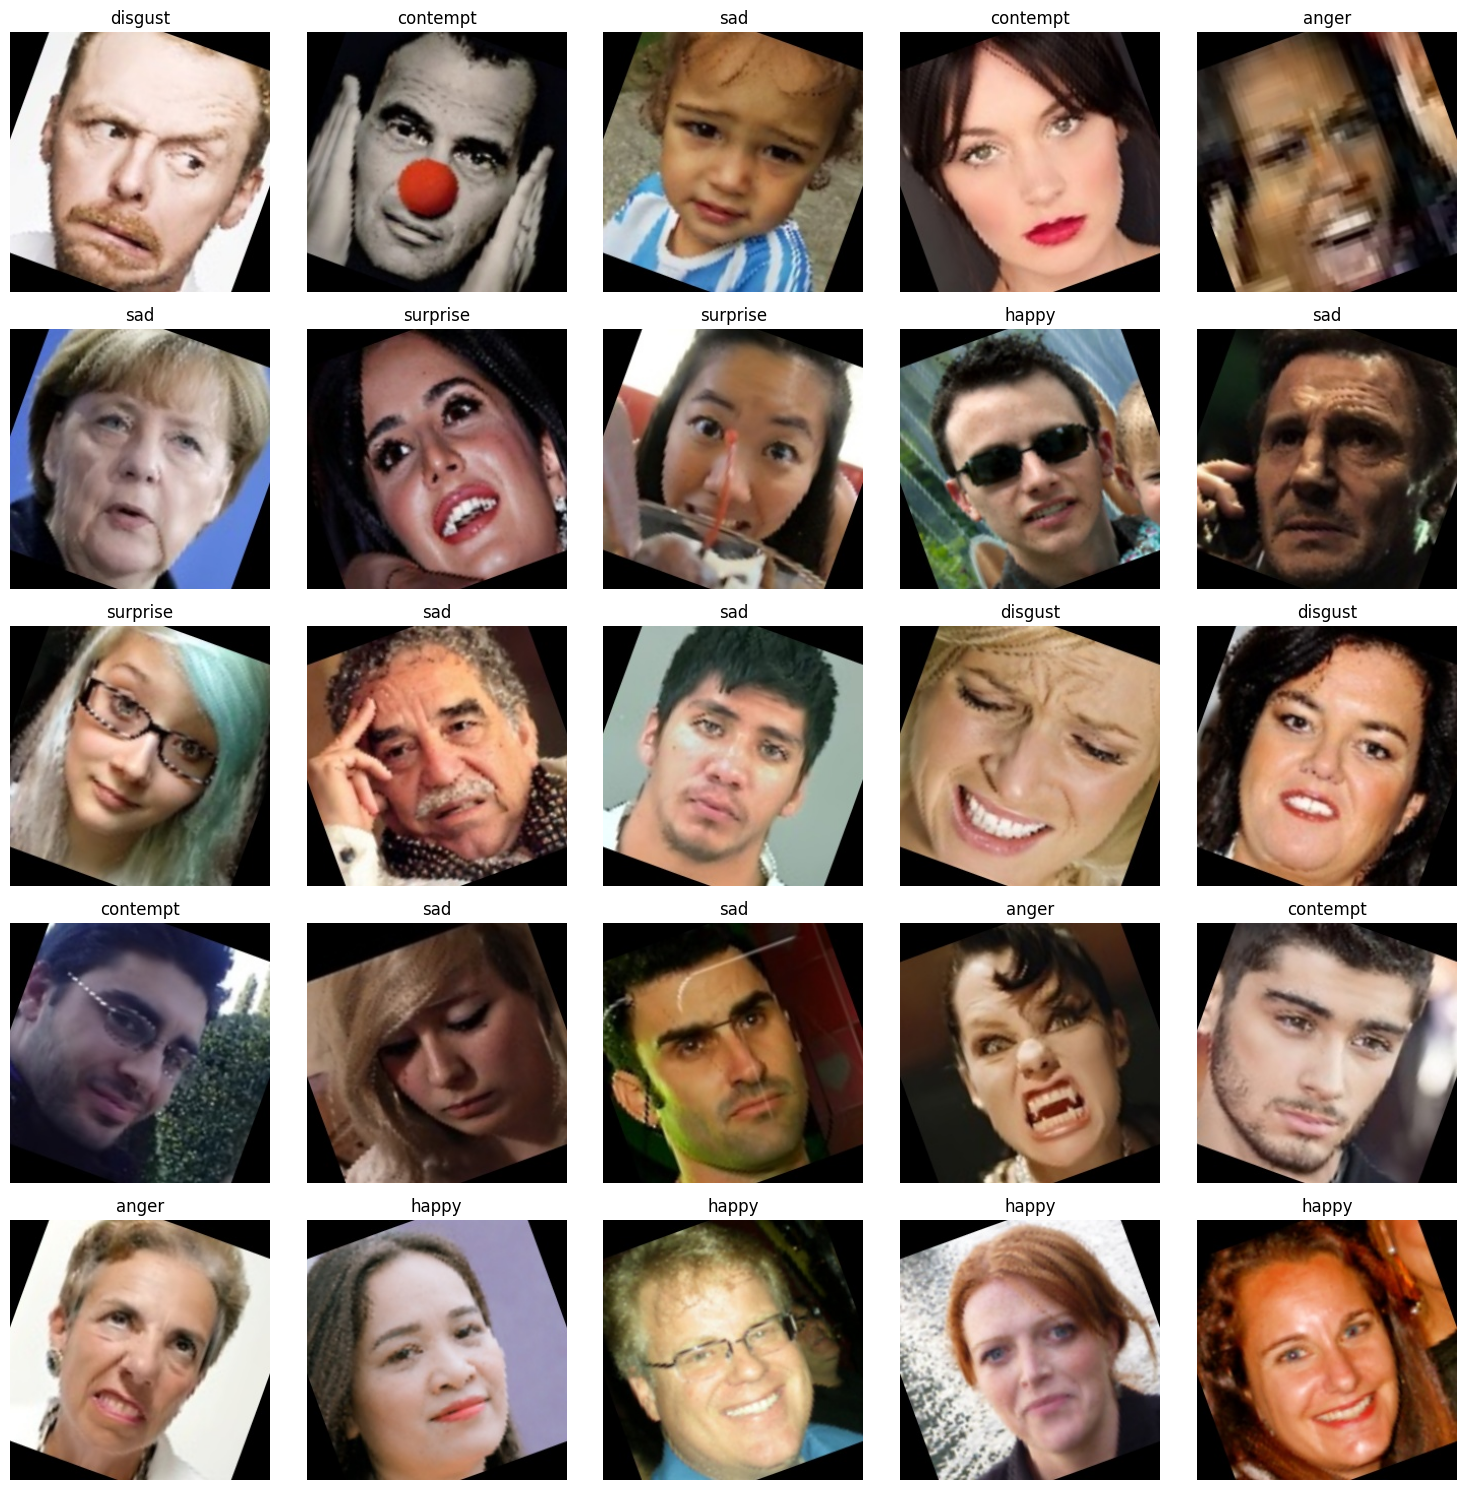

In [7]:
# Display sample images in a 5x5 grid
def display_sample_images_from_dir(input_dir, num_samples=25):
    image_paths, labels = get_image_paths_and_labels_from_dir(input_dir)
    sample_paths = random.sample(image_paths, num_samples)
    sample_labels = [labels[image_paths.index(path)] for path in sample_paths]
    
    images = [plt.imread(path) for path in sample_paths]

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()
    
    for img, label, ax in zip(images, sample_labels, axes):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show sample images from training directory
display_sample_images_from_dir(train_dir)

# Create Data Generators

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Create data generators
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 33536 images belonging to 8 classes.
Found 9582 images belonging to 8 classes.
Found 4796 images belonging to 8 classes.


# Model Evaluation Function

In [10]:
from sklearn.metrics import confusion_matrix

# Evaluate and plot confusion matrix
def evaluate_and_plot(model, test_generator):
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f'Test Accuracy: {test_acc:.4f}')

    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = test_generator.classes

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels.keys(), yticklabels=unique_labels.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [11]:
unique_labels = train_generator.class_indices
num_classes = len(unique_labels)

In [40]:
unique_labels

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

# Model Training

## VGG19 Model

In [12]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg19_model = Sequential([
    vgg19_base,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

vgg19_base.trainable = False
vgg19_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [14]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

vgg19_history = vgg19_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
524/524 [==============================] - 382s 701ms/step - loss: 3.6106 - accuracy: 0.2672 - val_loss: 2.2797 - val_accuracy: 0.3261 - lr: 0.0010
Epoch 2/50
524/524 [==============================] - 91s 174ms/step - loss: 1.9639 - accuracy: 0.3507 - val_loss: 1.8275 - val_accuracy: 0.3751 - lr: 0.0010
Epoch 3/50
524/524 [==============================] - 91s 173ms/step - loss: 1.7006 - accuracy: 0.3878 - val_loss: 1.7699 - val_accuracy: 0.3625 - lr: 0.0010
Epoch 4/50
524/524 [==============================] - 90s 171ms/step - loss: 1.6239 - accuracy: 0.3981 - val_loss: 1.6578 - val_accuracy: 0.3942 - lr: 0.0010
Epoch 5/50
524/524 [==============================] - 88s 168ms/step - loss: 1.6143 - accuracy: 0.4050 - val_loss: 1.6618 - val_accuracy: 0.3870 - lr: 0.0010
Epoch 6/50
524/524 [==============================] - 85s 163ms/step - loss: 1.6055 - accuracy: 0.4046 - val_loss: 1.6688 - val_accuracy: 0.3899 - lr: 0.0010
Epoch 7/50
524/524 [==============================]

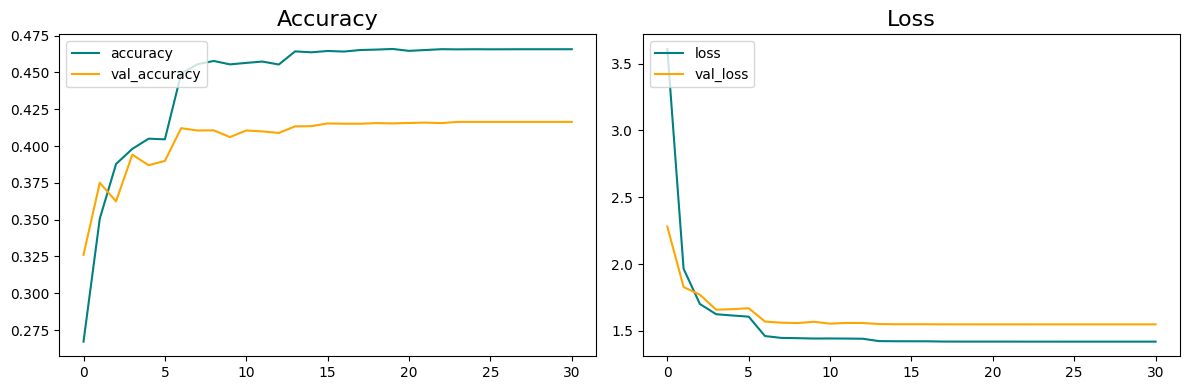

In [15]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(vgg19_history.history['accuracy'], color='teal', label='accuracy')
axes[0].plot(vgg19_history.history['val_accuracy'], color='orange', label='val_accuracy')
axes[0].set_title('Accuracy', fontsize=16)
axes[0].legend(loc="upper left")

# Plot loss
axes[1].plot(vgg19_history.history['loss'], color='teal', label='loss')
axes[1].plot(vgg19_history.history['val_loss'], color='orange', label='val_loss')
axes[1].set_title('Loss', fontsize=16)
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

Test Accuracy: 0.4120
75/75 [==============================] - 10s 123ms/step


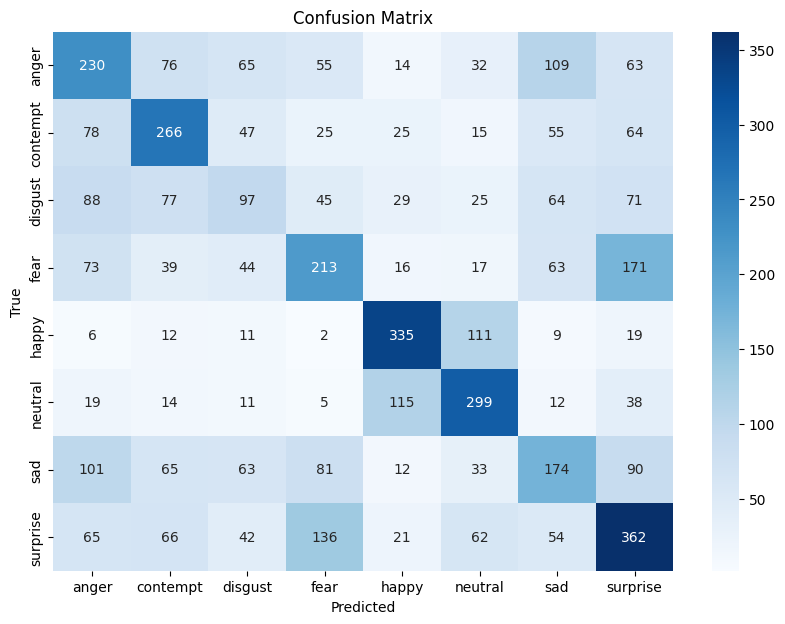

In [16]:
# Evaluate and plot for VGG19
evaluate_and_plot(vgg19_model, test_generator)

## MobileNet Model

In [17]:
from tensorflow.keras.applications import MobileNetV3Small

In [18]:
# Build and train MobileNetV3 model
mobilenetv3_base = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
mobilenetv3_model = Sequential([
    mobilenetv3_base,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

mobilenetv3_base.trainable = False
mobilenetv3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [19]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

mobilenetv3_history = mobilenetv3_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
524/524 [==============================] - 61s 107ms/step - loss: 1.7846 - accuracy: 0.3095 - val_loss: 1.6535 - val_accuracy: 0.3522 - lr: 0.0010
Epoch 2/50
524/524 [==============================] - 54s 103ms/step - loss: 1.6044 - accuracy: 0.3824 - val_loss: 1.6016 - val_accuracy: 0.3804 - lr: 0.0010
Epoch 3/50
524/524 [==============================] - 53s 102ms/step - loss: 1.5499 - accuracy: 0.4077 - val_loss: 1.5499 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 4/50
524/524 [==============================] - 53s 102ms/step - loss: 1.5201 - accuracy: 0.4178 - val_loss: 1.5369 - val_accuracy: 0.4032 - lr: 0.0010
Epoch 5/50
524/524 [==============================] - 54s 104ms/step - loss: 1.4979 - accuracy: 0.4294 - val_loss: 1.5231 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 6/50
524/524 [==============================] - 54s 104ms/step - loss: 1.4843 - accuracy: 0.4332 - val_loss: 1.5084 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 7/50
524/524 [==============================] 

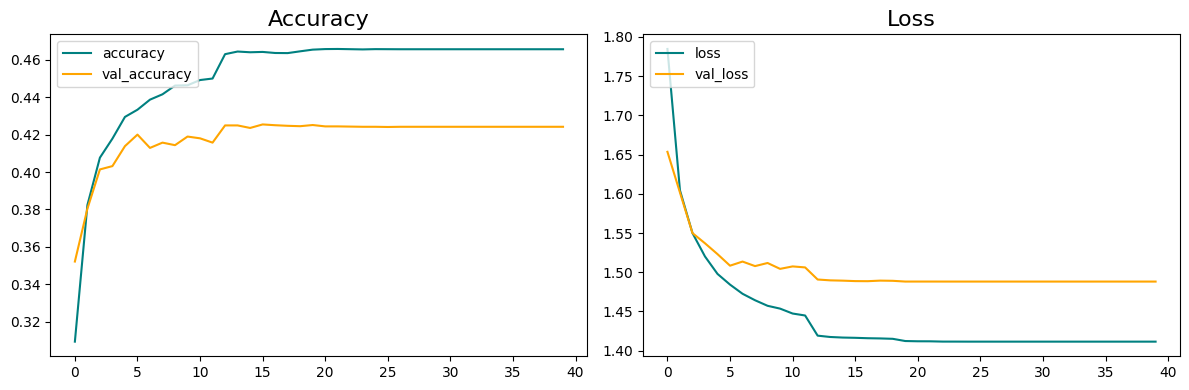

In [20]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(mobilenetv3_history.history['accuracy'], color='teal', label='accuracy')
axes[0].plot(mobilenetv3_history.history['val_accuracy'], color='orange', label='val_accuracy')
axes[0].set_title('Accuracy', fontsize=16)
axes[0].legend(loc="upper left")

# Plot loss
axes[1].plot(mobilenetv3_history.history['loss'], color='teal', label='loss')
axes[1].plot(mobilenetv3_history.history['val_loss'], color='orange', label='val_loss')
axes[1].set_title('Loss', fontsize=16)
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

Test Accuracy: 0.4247
75/75 [==============================] - 8s 88ms/step


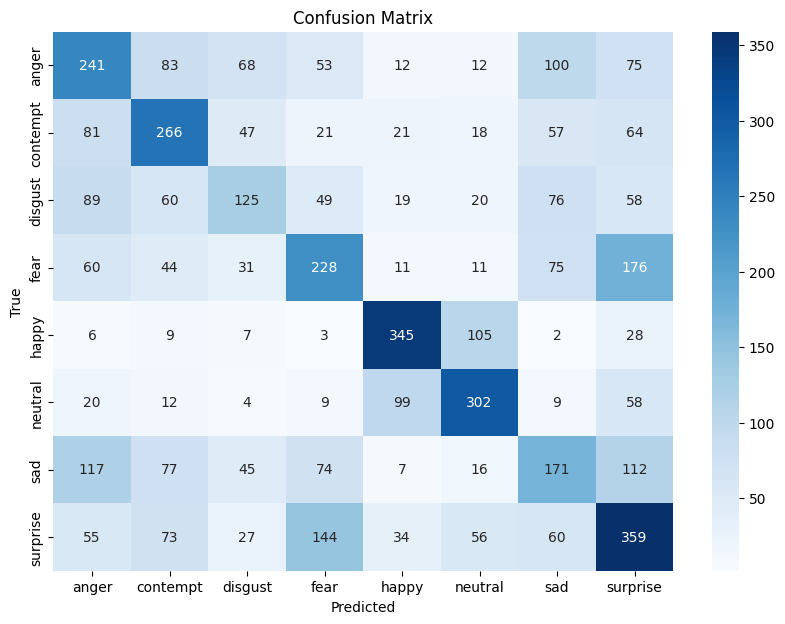

In [21]:
# Evaluate and plot for VGG19
evaluate_and_plot(mobilenetv3_model, test_generator)

## Resnet50 Model

In [22]:
from tensorflow.keras.applications import ResNet50

In [23]:
# Build and train ResNet50 model
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet50_model = Sequential([
    resnet50_base,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

resnet50_base.trainable = False
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [24]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

resnet50_history = resnet50_model.fit(train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
524/524 [==============================] - 64s 114ms/step - loss: 1.7537 - accuracy: 0.3515 - val_loss: 1.6175 - val_accuracy: 0.3726 - lr: 0.0010
Epoch 2/50
524/524 [==============================] - 57s 109ms/step - loss: 1.5019 - accuracy: 0.4290 - val_loss: 1.4972 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 3/50
524/524 [==============================] - 57s 109ms/step - loss: 1.4343 - accuracy: 0.4556 - val_loss: 1.4376 - val_accuracy: 0.4446 - lr: 0.0010
Epoch 4/50
524/524 [==============================] - 57s 109ms/step - loss: 1.3920 - accuracy: 0.4723 - val_loss: 1.5492 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 5/50
524/524 [==============================] - 59s 112ms/step - loss: 1.3483 - accuracy: 0.4914 - val_loss: 1.5719 - val_accuracy: 0.4140 - lr: 0.0010
Epoch 6/50
524/524 [==============================] - 57s 110ms/step - loss: 1.2246 - accuracy: 0.5429 - val_loss: 1.3871 - val_accuracy: 0.4658 - lr: 1.0000e-04
Epoch 7/50
524/524 [============================

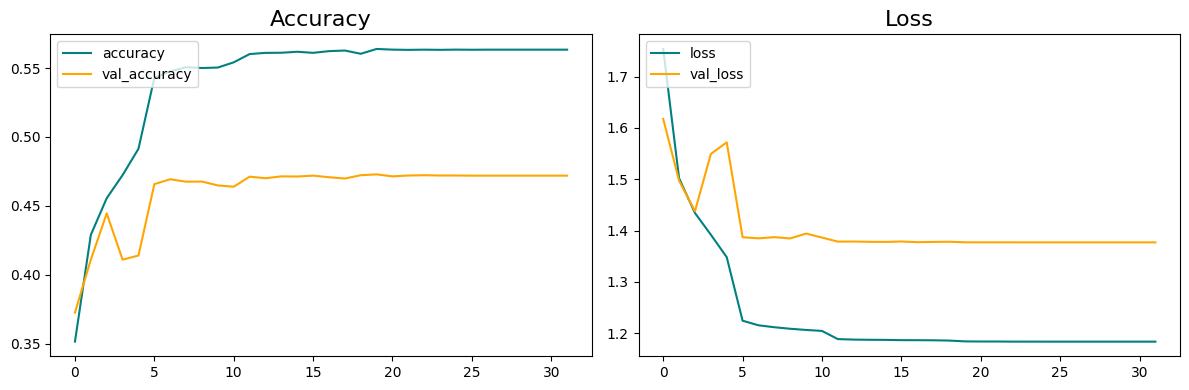

In [25]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(resnet50_history.history['accuracy'], color='teal', label='accuracy')
axes[0].plot(resnet50_history.history['val_accuracy'], color='orange', label='val_accuracy')
axes[0].set_title('Accuracy', fontsize=16)
axes[0].legend(loc="upper left")

# Plot loss
axes[1].plot(resnet50_history.history['loss'], color='teal', label='loss')
axes[1].plot(resnet50_history.history['val_loss'], color='orange', label='val_loss')
axes[1].set_title('Loss', fontsize=16)
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

Test Accuracy: 0.4729
75/75 [==============================] - 8s 87ms/step


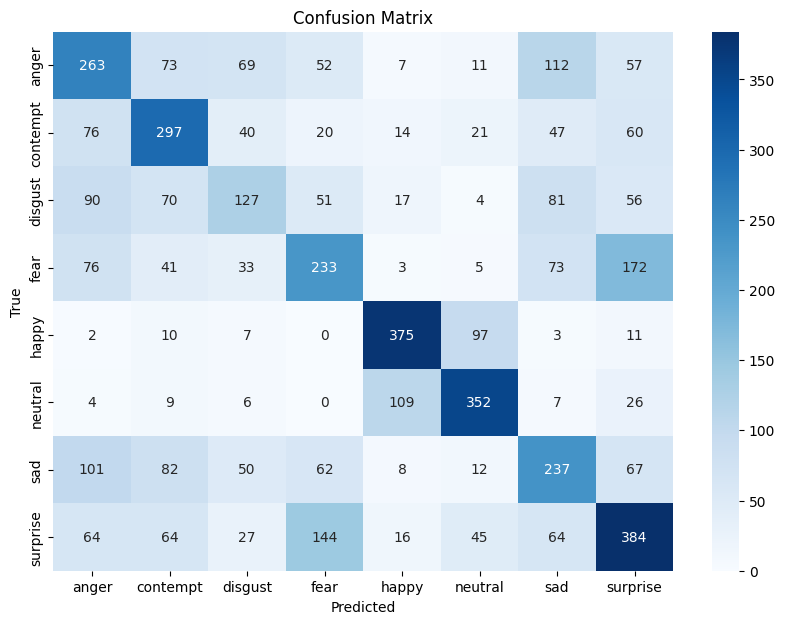

In [26]:
# Evaluate and plot for Resnet50
evaluate_and_plot(resnet50_model, test_generator)

## Advanced Technique

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

In [28]:
def build_ippm(input_tensor, pool_sizes):
  pyramid_pooling_outputs = []
  for pool_size in pool_sizes:
    # Upsample the input tensor
    upsampled = layers.UpSampling2D(size=(pool_size, pool_size), interpolation='nearest')(input_tensor)
    # Apply max pooling
    pooled = layers.MaxPooling2D(pool_size=(pool_size, pool_size))(upsampled)
    # Apply Conv2D with 128 filters and ReLU activation
    conv = layers.Conv2D(128, kernel_size=1, activation='relu')(pooled)
    pyramid_pooling_outputs.append(conv)
  # Concatenate all feature maps from different pyramid levels
  concatenated = layers.concatenate(pyramid_pooling_outputs)
  return concatenated

In [29]:
def build_advanced_model(input_shape, num_classes, pool_sizes):
  # Define the input layer
  inputs = layers.Input(shape=input_shape)

  # Load ResNet50 without the top layers (classification head)
  ResNet50_base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

  # Freeze the ResNet50 layers for transfer learning
  for layer in ResNet50_base.layers:
    layer.trainable = False

  # Implement Pyramid Pooling
  x = build_ippm(ResNet50_base.output, pool_sizes)

  # Add additional layers
  x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.GlobalAveragePooling2D()(x)

  # Define the output layer with softmax activation
  outputs = layers.Dense(num_classes, activation='softmax')(x)

  # Create the model
  model = Model(inputs=inputs, outputs=outputs)
  return model

In [30]:
# Set hyperparameters
input_shape = (128, 128, 3)
pool_sizes = [2, 3, 4, 6]

# Build the model
model = build_advanced_model(input_shape, num_classes, pool_sizes)

# Compile the model (optimizer, loss function, metrics)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [31]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


In [32]:
model_history = model.fit(train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
524/524 [==============================] - 70s 123ms/step - loss: 1.5487 - accuracy: 0.3803 - val_loss: 1.3839 - val_accuracy: 0.4572 - lr: 0.0010
Epoch 2/50
524/524 [==============================] - 62s 119ms/step - loss: 1.3120 - accuracy: 0.4837 - val_loss: 1.3153 - val_accuracy: 0.4865 - lr: 0.0010
Epoch 3/50
524/524 [==============================] - 64s 123ms/step - loss: 1.1954 - accuracy: 0.5350 - val_loss: 1.3027 - val_accuracy: 0.4937 - lr: 0.0010
Epoch 4/50
524/524 [==============================] - 63s 120ms/step - loss: 1.0762 - accuracy: 0.5853 - val_loss: 1.3397 - val_accuracy: 0.4941 - lr: 0.0010
Epoch 5/50
524/524 [==============================] - 62s 119ms/step - loss: 0.9464 - accuracy: 0.6439 - val_loss: 1.3407 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 6/50
524/524 [==============================] - 63s 120ms/step - loss: 0.6405 - accuracy: 0.7676 - val_loss: 1.3926 - val_accuracy: 0.5273 - lr: 1.0000e-04
Epoch 7/50
524/524 [============================

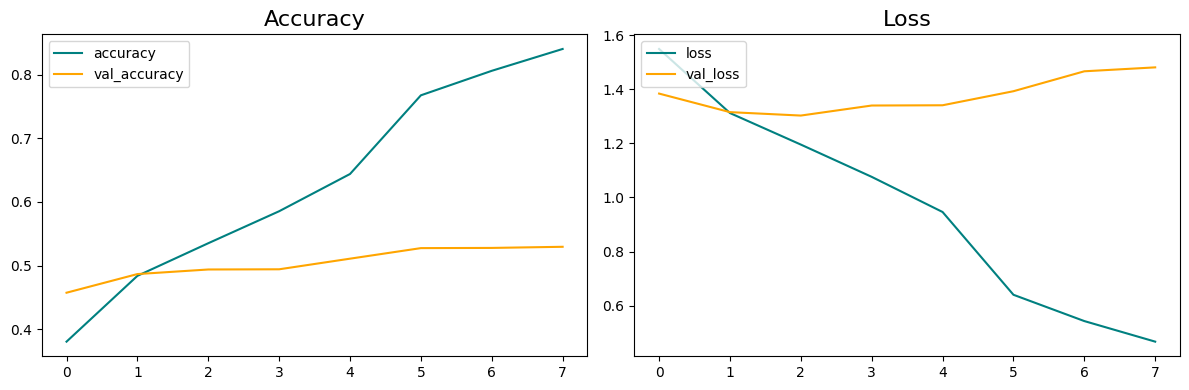

In [33]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(model_history.history['accuracy'], color='teal', label='accuracy')
axes[0].plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
axes[0].set_title('Accuracy', fontsize=16)
axes[0].legend(loc="upper left")

# Plot loss
axes[1].plot(model_history.history['loss'], color='teal', label='loss')
axes[1].plot(model_history.history['val_loss'], color='orange', label='val_loss')
axes[1].set_title('Loss', fontsize=16)
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

Test Accuracy: 0.5269
75/75 [==============================] - 8s 92ms/step


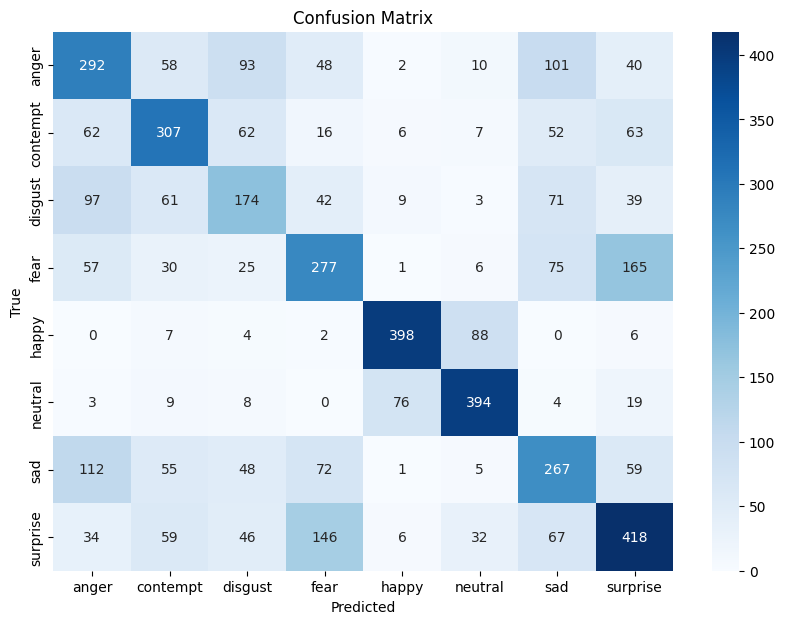

In [34]:
# Evaluate and plot for Advanced Model
evaluate_and_plot(model, test_generator)

In [35]:
# Save the model
model.save('advanced_model.h5')  # Save model as HDF5 file

In [41]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

In [42]:
# Load the trained ResNet50 model
model = load_model('advanced_model.h5')